In [264]:
pip install holidays-es

Note: you may need to restart the kernel to use updated packages.


In [265]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
from holidays_es import Province

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

sns.set_context('poster')
sns.set(rc={'figure.figsize': (14., 8.)})
sns.set_style('whitegrid')

## 0 - Obtención de datos 

In [99]:
temperatura = pd.read_excel('../data/AEMET_temperature_data_2014-2020.xlsx', parse_dates=[0])

In [100]:
temperatura.rename(columns={'Unnamed: 0': 'date', 'T (ºC)': 'Temperature'}, inplace=True)

In [106]:
temperatura.head()

,date,Temperature
0,2014-01-01,11.48750
1,2014-01-02,13.08750
2,2014-01-03,14.43125
3,2014-01-04,11.98125
4,2014-01-05,10.94375


In [105]:
temperatura.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2557 non-null   datetime64[ns]
 1   Temperature  2557 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 40.1 KB


In [107]:
temperatura.set_index('date',inplace=True)

In [108]:
temperatura.head()

,Temperature
date,
2014-01-01,11.48750
2014-01-02,13.08750
2014-01-03,14.43125
2014-01-04,11.98125
2014-01-05,10.94375


<AxesSubplot:xlabel='date'>

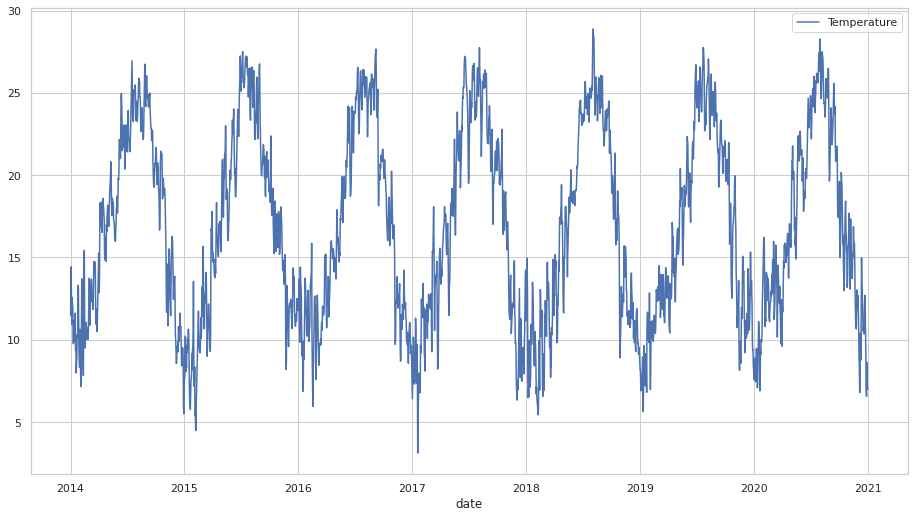

In [126]:
sns.lineplot(data=temperatura)

In [174]:
demanda = pd.read_csv('../data/export_DemandaReal_2022-02-28_20_21.csv', sep=';', parse_dates=[5])

In [175]:
demanda.head()

,id,name,geoid,geoname,value,datetime
0,1293,Demanda real,NaN,NaN,23021.076389,2014-01-01 00:00:00+01:00
1,1293,Demanda real,NaN,NaN,28191.597222,2014-01-02 00:00:00+01:00
2,1293,Demanda real,NaN,NaN,28465.180556,2014-01-03 00:00:00+01:00
3,1293,Demanda real,NaN,NaN,26860.493056,2014-01-04 00:00:00+01:00
4,1293,Demanda real,NaN,NaN,25333.597222,2014-01-05 00:00:00+01:00


In [176]:
demanda.datetime=pd.to_datetime(demanda['datetime'], utc=True)

In [177]:
demanda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   id        2557 non-null   int64              
 1   name      2557 non-null   object             
 2   geoid     0 non-null      float64            
 3   geoname   0 non-null      float64            
 4   value     2557 non-null   float64            
 5   datetime  2557 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(3), int64(1), object(1)
memory usage: 120.0+ KB


In [178]:
demanda.datetime=pd.to_datetime(demanda['datetime'], utc=True)

In [179]:
demanda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   id        2557 non-null   int64              
 1   name      2557 non-null   object             
 2   geoid     0 non-null      float64            
 3   geoname   0 non-null      float64            
 4   value     2557 non-null   float64            
 5   datetime  2557 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(3), int64(1), object(1)
memory usage: 120.0+ KB


In [188]:
demanda['date'] =demanda.datetime.dt.date

In [195]:
demanda = demanda[['date', 'value']]

In [192]:
demanda.date = pd.to_datetime(demanda.date)

In [196]:
demanda.head()

,date,value
0,2013-12-31,23021.076389
1,2014-01-01,28191.597222
2,2014-01-02,28465.180556
3,2014-01-03,26860.493056
4,2014-01-04,25333.597222


In [197]:
demanda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2557 non-null   datetime64[ns]
 1   value   2557 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 40.1 KB


In [199]:
demanda.set_index('date',inplace=True)

In [200]:
demanda.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2557 entries, 2013-12-31 to 2020-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   2557 non-null   float64
dtypes: float64(1)
memory usage: 40.0 KB


<AxesSubplot:xlabel='date'>

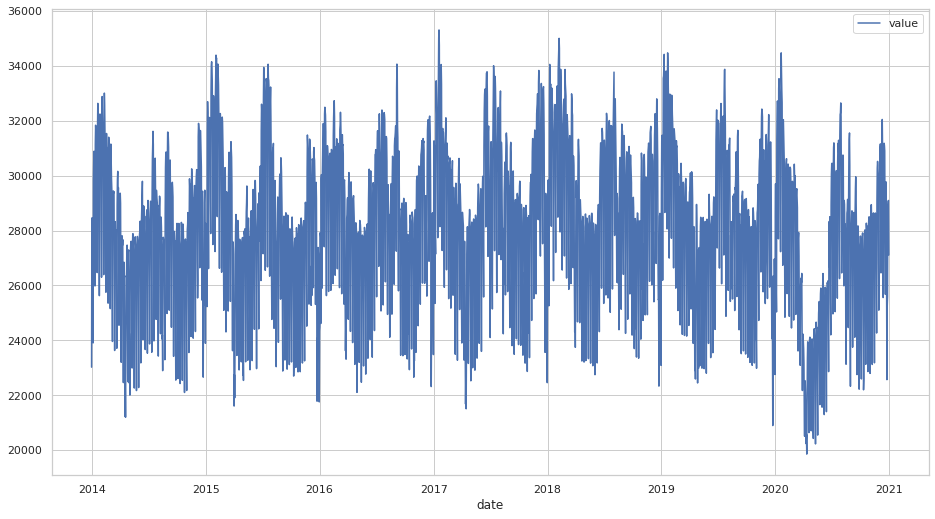

In [201]:
sns.lineplot(data=demanda)

In [202]:
demanda.head()

,value
date,
2013-12-31,23021.076389
2014-01-01,28191.597222
2014-01-02,28465.180556
2014-01-03,26860.493056
2014-01-04,25333.597222


In [205]:
temp_dem = pd.merge(temperatura, demanda, left_index=True, right_index=True)

In [207]:
temp_dem

,Temperature,value
date,,
2014-01-01,11.48750,28191.597222
2014-01-02,13.08750,28465.180556
2014-01-03,14.43125,26860.493056
2014-01-04,11.98125,25333.597222
2014-01-05,10.94375,23905.541667
...,...,...
2020-12-26,6.85000,25605.138889
2020-12-27,6.55625,28812.750000
2020-12-28,8.61875,29063.493056


In [209]:
temp_dem.corr()

,Temperature,value
Temperature,1.000000,-0.099375
value,-0.099375,1.000000


In [236]:
url = "https://www.dias-laborables.es/data_excel.php?step=1&from=2014-01-01&to=2020-12-01&cols=13,1,0;13,1,1;13,1,3;"
html = requests.get(url)
soup = BeautifulSoup(html.content,"html.parser")

In [237]:
tablas = soup.findAll("table")

In [238]:
tabla_dias_laborables = tablas[3]

In [239]:
tabla_dias_laborables.findAll('tr') [1].findAll('td')[0].getText().strip()

'mié, 1 ene, 2014'

In [235]:
tabla_dias_laborables.findAll('tr') [1].findAll('td')[99].getText().strip()

IndexError: list index out of range

In [243]:
type(tabla_dias_laborables.findAll('tr'))

bs4.element.ResultSet

In [244]:
def is_business_day(date):
    return bool(len(pd.bdate_range(date, date)))

In [246]:
is_business_day(temp_dem.index[0])

True

In [259]:
def business_days(df):
    buss_day = []
    for i in range(len(df.index)):
        
        if is_business_day(df.index[i]):
            buss_day.append(1)
        else:
            buss_day.append(0)
    return buss_day

In [261]:
temp_dem['Laborable'] = business_days(temp_dem)

In [263]:
temp_dem.head(15)

,Temperature,value,Laborable
date,,,
2014-01-01,11.487500,28191.597222,1
2014-01-02,13.087500,28465.180556,1
2014-01-03,14.431250,26860.493056,1
2014-01-04,11.981250,25333.597222,0
2014-01-05,10.943750,23905.541667,0
2014-01-06,12.566667,29859.201389,1
2014-01-07,12.133333,30573.444444,1
2014-01-08,12.037500,30887.750000,1
2014-01-09,10.387500,30847.819444,1


In [256]:
temp_dem.index[0]

Timestamp('2014-01-01 00:00:00')

In [269]:
Province(name="madrid").national_holidays()[0]

datetime.date(2022, 1, 1)